In [1]:
from __future__ import print_function
import pyemma
pyemma.__version__

'2.4'

In [2]:
import os
%pylab inline
matplotlib.rcParams.update({'font.size': 12})

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt

In [4]:
indir = '../Data/proc_traj'
topfile =  indir+'/2agy-as1.prmtop'
from glob import glob
traj_list = glob(indir+'/2agy-*-as1.nc')

In [5]:
import numpy as np
import pickle
high_dihed = np.load('../Common/high_variance_dihedrals_active_site.npy')
print(len(high_dihed))
all_dihed = pickle.load(open('../Common/2agy_as-1_dihedrals.pickl', 'rb'))
print(len(all_dihed))

34
159


## High variance only
Let's make a model with only the high variance dihdral angles included. Later on we'll add all the dihedrals and see how that compares. We'll use some standard parameters for tica and the number of clusters and then optimize using Osprey later. 

In [6]:
# add_dihedrals(indexes, deg=False, cossin=False, periodic=True)
feat = coor.featurizer(topfile)
feat.add_dihedrals(indexes=high_dihed, cossin=True, periodic=True)
feat.dimension()


68

In [7]:
inp = coor.load(traj_list, feat)
# print('number of trajectories = ',inp.number_of_trajectories())
# print('trajectory length = ',inp.trajectory_length(0))
# print('trajectory time step = ',100 / (inp.trajectory_length(0)),'ns')
# print('number of dimension = ',inp.dimension())

In [8]:
dt = 0.01 # 0.01 ns time step. 
stride = 100 # 1 ns stride data

### tICA
Let's find the smallest number of components that give 95% variance retained by varying the lag time. 

In [9]:
lags = np.arange(5, 95, 5)
n_timescales = 20
timescales = np.zeros((lags.shape[0], n_timescales))
for i, lag in enumerate(lags):
    tica_obj = coor.tica(inp, lag=int(lag/dt), var_cutoff=0.95, kinetic_map=True, stride=100)
    timescales[i] = tica_obj.timescales[:n_timescales]
    print('Lag {0} TICA dimension {1}'.format(lag, tica_obj.dimension()))

Lag 5 TICA dimension 7
Lag 10 TICA dimension 6
Lag 15 TICA dimension 6
Lag 20 TICA dimension 6
Lag 25 TICA dimension 5
Lag 30 TICA dimension 4
Lag 35 TICA dimension 4
Lag 40 TICA dimension 4
Lag 45 TICA dimension 4
Lag 50 TICA dimension 4
Lag 55 TICA dimension 3
Lag 60 TICA dimension 3
Lag 65 TICA dimension 3
Lag 70 TICA dimension 4
Lag 75 TICA dimension 4
Lag 80 TICA dimension 4
Lag 85 TICA dimension 5
Lag 90 TICA dimension 5


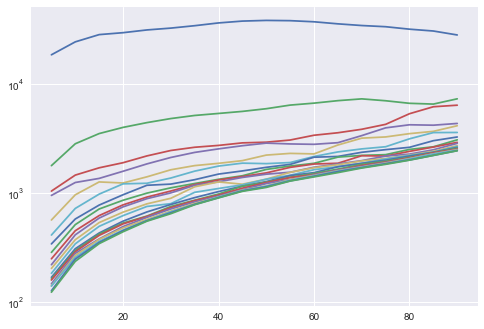

In [10]:
import seaborn as sns
for i in range(n_timescales):
    plt.plot(lags, timescales.T[i])
    plt.yscale('log')

A lag time of 30ns seems reasonable as any less than that adds more dimensions necessary to describe 95% of the data. Let's explore the free energy

In [11]:
tica_lag = 30
tica_obj = coor.tica(inp, lag=int(tica_lag/dt), var_cutoff=0.95, kinetic_map=True, stride=100)

In [12]:
Y = tica_obj.get_output()

In [13]:
n_dims = tica_obj.dimension()

/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


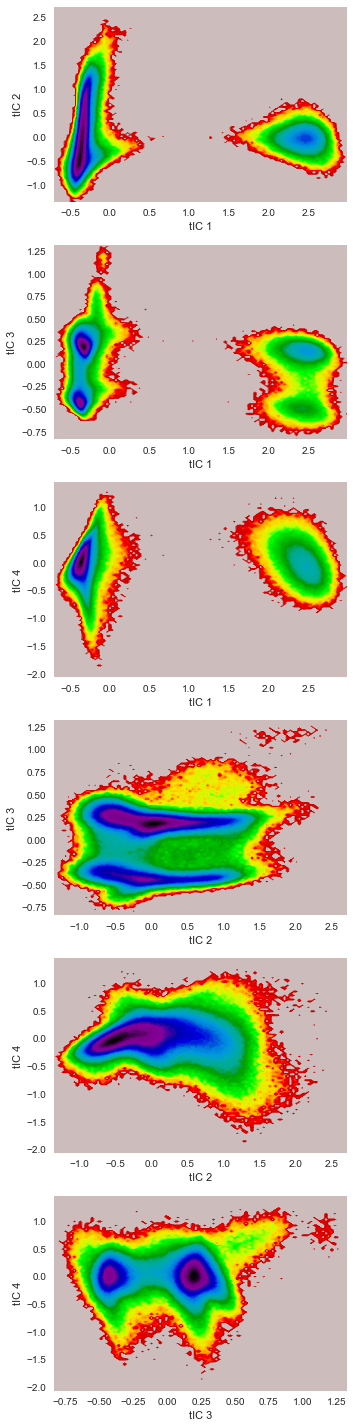

In [23]:
from itertools import combinations
from scipy.misc import comb

n_plots = comb(n_dims, 2)
fig, axes = plt.subplots(int(n_plots), 1,figsize=(5,20))
for idx, (i, j) in enumerate(combinations(range(n_dims), 2)):
    
    fig, ax = mplt.plot_free_energy(np.vstack(Y)[:,i], np.vstack(Y)[:,j], cbar=False, ax=axes.flatten()[idx]);
    ax.set_ylabel('tIC {}'.format(j+1))
    ax.set_xlabel('tIC {}'.format(i+1))
plt.tight_layout()


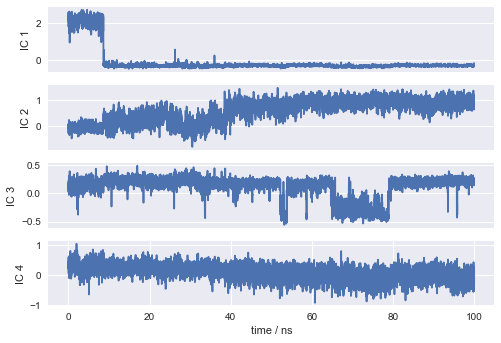

In [20]:
#### figure(figsize(8,5))
ax1=plt.subplot(411)
x = dt*np.arange(Y[0].shape[0])
traj_num = 1
plot(x, Y[traj_num][:,0]); ylabel('IC 1'); xticks([]);
ax1=plt.subplot(412)
plot(x, Y[traj_num][:,1]); ylabel('IC 2'); xticks([]); 
ax1=plt.subplot(413)
plot(x, Y[traj_num][:,2]); xticks([]); ylabel('IC 3'); 
ax1=plt.subplot(414)
plot(x, Y[traj_num][:,3]); xlabel('time / ns'); ylabel('IC 4'); 

### Cluster

In [35]:
n_trajs = len(inp)
n_frames = inp[0].shape[0]
n_trajs

100

In [30]:
n_clusters = int(np.sqrt(n_trajs*n_frames/stride))
n_clusters

100

In [37]:
clustering = coor.cluster_kmeans(Y,k=n_clusters, max_iter=100, stride=stride)


30-10-17 16:45:29 pyemma.coordinates.clustering.kmeans.KmeansClustering[41] INFO     Cluster centers converged after 23 steps.


In [40]:
dtrajs = clustering.get_output(stride=stride)

In [44]:
dtrajs = [dtraj.flatten() for dtraj in dtrajs]

/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


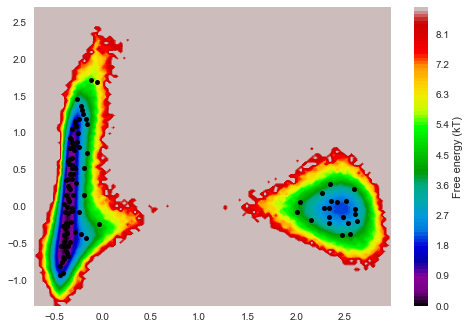

In [45]:
mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1])
cc_x = clustering.clustercenters[:,0]
cc_y = clustering.clustercenters[:,1]
plot(cc_x,cc_y, linewidth=0, marker='o', markersize=5, color='black')

### Implied timescales

In [57]:
its = msm.timescales_msm(dtrajs, lags=list(np.arange(10, 70, 2)), nits=10, errors='bayes')


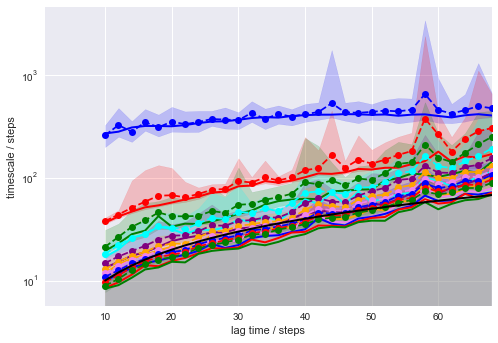

In [58]:
matplotlib.rcParams.update({'font.size': 14})
mplt.plot_implied_timescales(its, ylog=True, units='steps', linewidth=2)
# xlim(0, 100); ylim(0, 120);

This looks good.  Let's create an MSM with a lag time of 30ns. 

In [74]:
msm_lag = 30
M = msm.estimate_markov_model(dtrajs, msm_lag)
print('fraction of states used = ', M.active_state_fraction)
print('fraction of counts used = ', M.active_count_fraction)

fraction of states used =  1.0
fraction of counts used =  1.0


In [81]:
M = msm.bayesian_markov_model(dtrajs=dtrajs, lag=msm_lag, nsamples=10000)


In [78]:
ck = M.cktest(nsets=2, mlags=None, err_est=False)


(<matplotlib.figure.Figure at 0x12c6722e8>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12c672b70>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x16deea9e8>]], dtype=object))

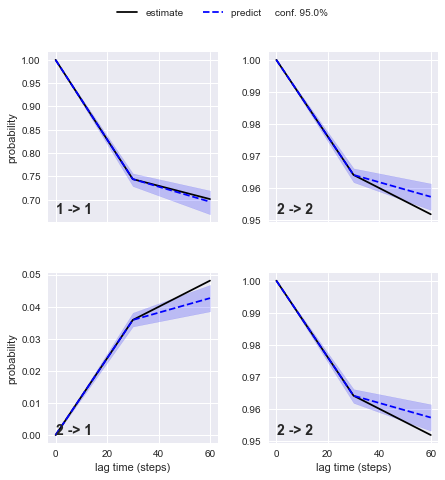

In [79]:
matplotlib.rcParams.update({'font.size': 14})
mplt.plot_cktest(ck, diag=True, figsize=(7,7), layout=(2,2), padding_top=0.1, y01=False, padding_between=0.3)
